## ML 프로젝트 | 1. 커피머신 리뷰 분석

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

review = pd.read_csv('다나와 리뷰 크롤링.csv')

- 데이터 소스: 다나와
- 수동/반자동 커피머신 리뷰많은 순서로 <span style="color: red">50개</span>의 제품 분석 

### 중복 제거 & 테이블 정리

In [2]:
# 중복제거
review = review.drop_duplicates().reset_index(drop=True) 

# 제품명에서 브랜드 분리
review['brand'] = review['product_name'].str.split(' ').str[0]
review['product_name'] = review['product_name'].str.split(' ').str[1:].apply(' '.join)

# 컬럼 순서 정리, 점수 타입 변경
review = review[['mall', 'brand', 'product_name', 'title', 'score', 'review', 'reviewer', 'date']]
review['score'] = review['score'].str.replace('점', '').astype(int)

review.head(3)

,mall,brand,product_name,title,score,review,reviewer,date
0,옥션,중산물산,위즈웰 DL-310 (일반구매),씻는게 불편하긴 하지만 잘돼네요,100,씻는게 불편하긴 하지만 잘돼네요,sk****,2023.02.16.
1,G마켓,중산물산,위즈웰 DL-310 (일반구매),배송도 빠르고,100,가격도 저렴하니 좋네요,ke****,2023.01.07.
2,옥션,중산물산,위즈웰 DL-310 (일반구매),역시 새제품이라 크래마가 굿,100,역시 새제품이라 크래마가 굿,le****,2024.01.25.


### 리뷰 갯수가 제일 많은 쇼핑몰 Top 10

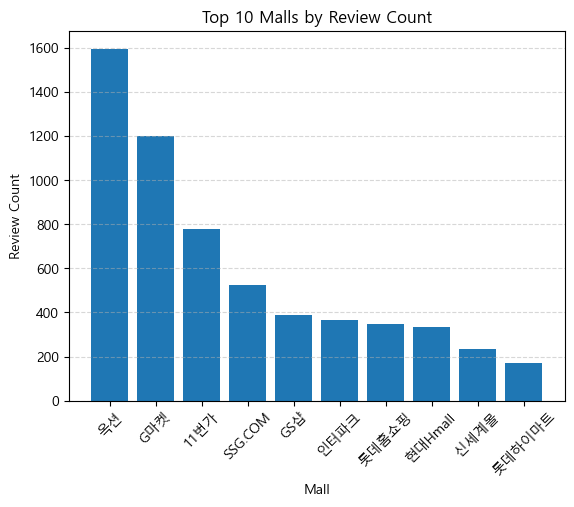

In [3]:
mall_review_count = review['mall'].value_counts().reset_index()
mall_review_count.columns = ['mall', 'review_count']

top_10_malls = mall_review_count.head(10)
bottom_10_malls = mall_review_count.tail(10) 

top_10_malls_sorted = top_10_malls.sort_values(by='review_count', ascending=False)

plt.bar(top_10_malls_sorted['mall'], top_10_malls_sorted['review_count'])
plt.title('Top 10 Malls by Review Count')
plt.xlabel('Mall')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

- <span style='background-color: #F7DDBE'>리뷰 데이터에서 쿠팡 데이터는 찾아볼 수 없다.</span>
- 쿠팡을 제외한 메이저 쇼핑몰은 옥션, G마켓, 11번가, 쓱닷컴 등이 있다.

### 리뷰 갯수가 제일 적은 쇼핑몰 Bottom 10

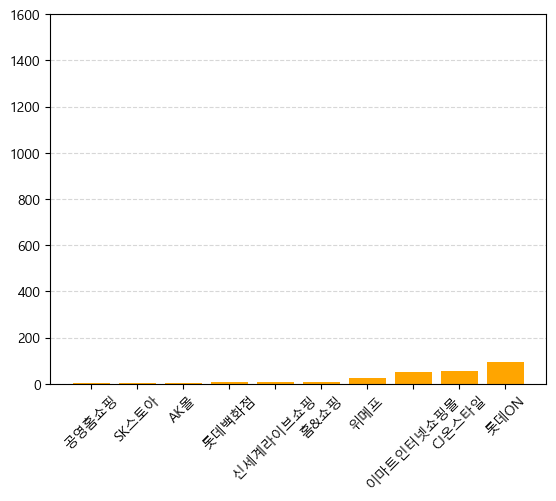

In [4]:
y_max_limit = 1600
bottom_10_malls_sorted = bottom_10_malls.sort_values(by='review_count')
plt.bar(bottom_10_malls_sorted['mall'], bottom_10_malls_sorted['review_count'], color='orange')
plt.xticks(rotation=45)
plt.ylim(0, y_max_limit)  # Set the y-axis limit to match the Top 10 graph
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 쇼핑몰별 평균 평점

In [5]:
mall_score_analysis = review.groupby('mall').agg(
    average_score=('score', lambda x: round(x.mean(), 1)),
    review_count=('score', 'count')
).reset_index()

# Sort by average score to find malls with highest and lowest scores
top_malls_by_score = mall_score_analysis.sort_values(by='average_score', ascending=False).head(10)
bottom_malls_by_score = mall_score_analysis.sort_values(by='average_score').head(10)


In [6]:
top_malls_by_score

,mall,average_score,review_count
5,SK스토아,100.0,3
7,공영홈쇼핑,100.0,1
16,이마트인터넷쇼핑몰,99.6,49
13,신세계몰,99.5,236
6,SSG.COM,96.9,526
11,롯데홈쇼핑,96.7,347
2,CJ온스타일,96.1,56
10,롯데하이마트,96.0,170
9,롯데백화점,95.6,9
18,현대Hmall,95.6,333


리뷰의 신뢰도를 높이기 위해, <span style="color: red">리뷰 개수가 적은 경우 평균 평점이 높은 점수를 기록하더라도 신뢰성이 떨어질 수 있으므로</span> 이를 고려한 방법을 사용 할 필요가 있음
- 베이지안 평균 + 리뷰 30개 이상 데이터 

In [7]:
# Define the overall average score and minimum number of reviews for Bayesian average calculation
overall_average_score = review['score'].mean()
min_reviews_threshold = 30  # Only include malls with 30 or more reviews

# Function to calculate Bayesian average
def bayesian_average(row, overall_avg, min_reviews):
    r = row['review_count']
    avg = row['average_score']
    return (r * avg + min_reviews * overall_avg) / (r + min_reviews)

# Group by mall, calculate average score and review count
mall_score_analysis = review.groupby('mall').agg(
    average_score=('score', lambda x: round(x.mean(), 1)),
    review_count=('score', 'count')
).reset_index()

# Filter to only include malls with 30 or more reviews
mall_score_analysis = mall_score_analysis[mall_score_analysis['review_count'] >= min_reviews_threshold]

# Apply Bayesian average
mall_score_analysis['bayesian_score'] = mall_score_analysis.apply(
    bayesian_average, args=(overall_average_score, min_reviews_threshold), axis=1
)

# Sort by Bayesian score to find top and bottom malls
top_malls_by_bayesian = mall_score_analysis.sort_values(by='bayesian_score', ascending=False).head(5)
bottom_malls_by_bayesian = mall_score_analysis.sort_values(by='bayesian_score').head(5)

In [8]:
top_malls_by_bayesian

,mall,average_score,review_count,bayesian_score
13,신세계몰,99.5,236,98.810818
16,이마트인터넷쇼핑몰,99.6,49,97.241490
6,SSG.COM,96.9,526,96.710571
11,롯데홈쇼핑,96.7,347,96.436546
10,롯데하이마트,96.0,170,95.608388


- <span style='background-color: #dcffe4'>신세계, 이마트 인터넷 쇼핑몰, 쓱닷컴이 100점에 근사하게 평점이 가장 높음</span>

In [9]:
bottom_malls_by_bayesian

,mall,average_score,review_count,bayesian_score
0,11번가,90.0,779,90.125683
4,G마켓,91.3,1200,91.350957
3,GS샵,91.2,387,91.357500
14,옥션,92.9,1597,92.909021
8,롯데ON,93.6,94,93.549014


- 리뷰가 상대적으로 많은 옥션, G마켓, 11번가가 하위 랭킹을 차지함

### 신세계 계열사의 쇼핑몰이 평점이 1,2,3위로 가장 높다. 혹시 리뷰 조작을 하는것은 아닐까?

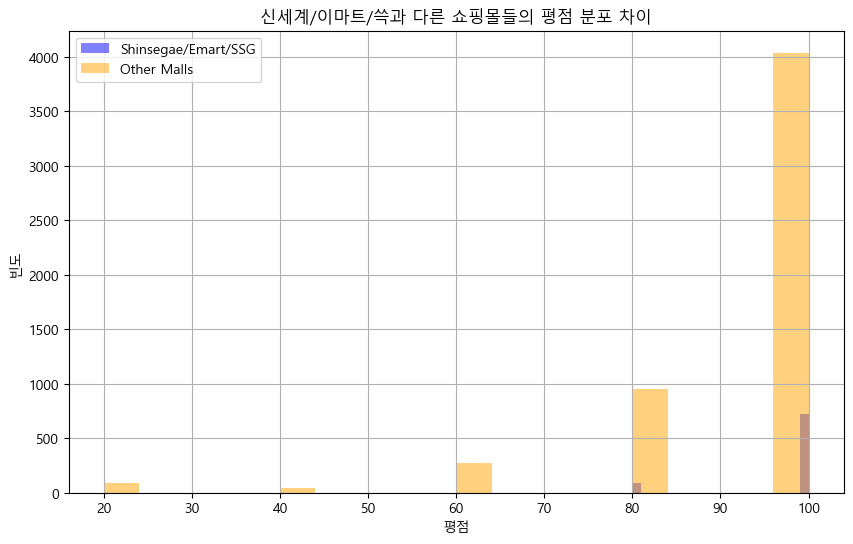

In [10]:
selected_malls = ["신세계몰", "이마트인터넷쇼핑몰", "SSG.COM"]
selected_malls_data = review[review['mall'].isin(selected_malls)]
other_malls_data = review[~review['mall'].isin(selected_malls)]

plt.figure(figsize=(10, 6))

plt.hist(selected_malls_data['score'], bins=20, alpha=0.5, label="Shinsegae/Emart/SSG", color='blue')

plt.hist(other_malls_data['score'], bins=20, alpha=0.5, label="Other Malls", color='orange')

plt.title("신세계/이마트/쓱과 다른 쇼핑몰들의 평점 분포 차이")
plt.xlabel("평점")
plt.ylabel("빈도")
plt.legend()
plt.grid(True)
plt.show()


- 평점 분포가 확실히 신세계 계열사가 높다

### 혹시 리뷰 길이와 평점이 상관이 있을까?

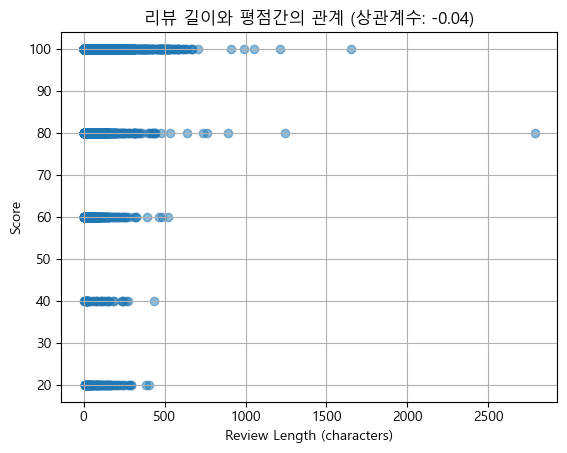

-0.04334271790469985

In [11]:
review['review_length'] = review['review'].str.len()

review_length_score_correlation = review[['review_length', 'score']].corr().iloc[0, 1]

plt.scatter(review['review_length'], review['score'], alpha=0.5)
plt.title(f'리뷰 길이와 평점간의 관계 (상관계수: {review_length_score_correlation:.2f})')
plt.xlabel('Review Length (characters)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

review_length_score_correlation

- 결과로 봐서는 딱히 그렇지는 않다 <span style="color: red">혹시 신세계 계열사에서 평점이 좋은 상품만 판매하는게 아닐까?</span>

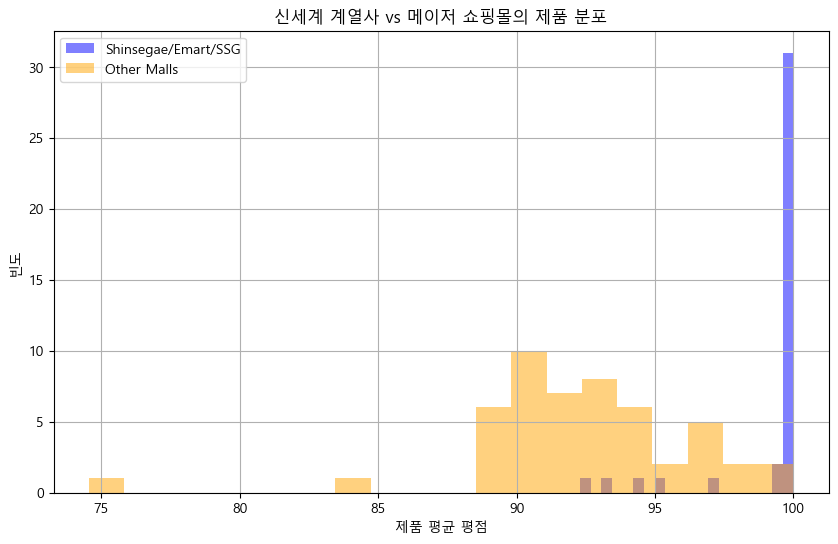

In [12]:
selected_malls_product_avg = selected_malls_data.groupby('product_name').agg(
    average_score=('score', 'mean')
).reset_index()

other_malls_product_avg = other_malls_data.groupby('product_name').agg(
    average_score=('score', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))

plt.hist(selected_malls_product_avg['average_score'], bins=20, alpha=0.5, label="Shinsegae/Emart/SSG", color='blue')

plt.hist(other_malls_product_avg['average_score'], bins=20, alpha=0.5, label="Other Malls", color='orange')

plt.title("신세계 계열사 vs 메이저 쇼핑몰의 제품 분포")
plt.xlabel("제품 평균 평점")
plt.ylabel("빈도")
plt.legend()
plt.grid(True)
plt.show()


- 이 결과로 볼 때, 신세계, 이마트, SSG.COM에서는 평균적으로 평점이 높은 제품만 판매하는 경향이 있거나, 상대적으로 더 엄선된 제품을 판매할 가능성이 있는 반면, 다른 쇼핑몰은 고평점 제품이 더 적게 포함된 것으로 보인다

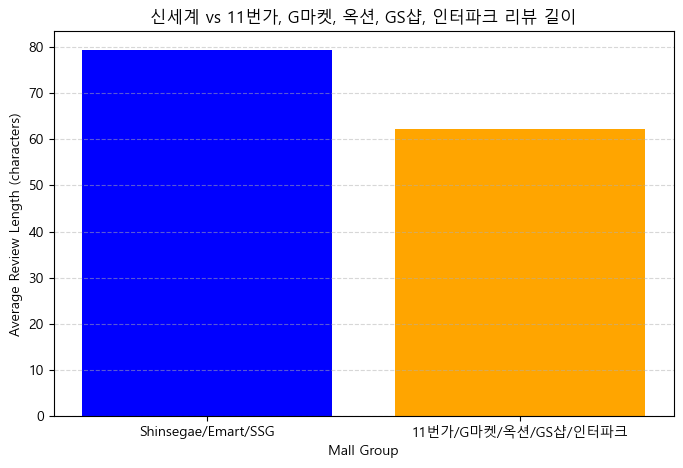

{'Shinsegae/Emart/SSG': 79.40937114673243,
 '11번가/G마켓/옥션/GS샵/인터파크': 62.20230946882217}

In [13]:
selected_malls = ["신세계몰", "이마트인터넷쇼핑몰", "SSG.COM"]
specific_other_malls = ["11번가", "G마켓", "옥션", "GS샵", "인터파크"]

# Filter data for each group using .loc to avoid warnings
selected_malls_data = review.loc[review['mall'].isin(selected_malls)].copy()
specific_other_malls_data = review.loc[review['mall'].isin(specific_other_malls)].copy()

# Calculate review lengths for each group
selected_malls_data['review_length'] = selected_malls_data['review'].str.len()
specific_other_malls_data['review_length'] = specific_other_malls_data['review'].str.len()

# Calculate the average review length for each group
average_length_selected_malls = selected_malls_data['review_length'].mean()
average_length_specific_other_malls = specific_other_malls_data['review_length'].mean()

# Prepare data for bar plot
average_lengths = {
    "Shinsegae/Emart/SSG": average_length_selected_malls,
    "11번가/G마켓/옥션/GS샵/인터파크": average_length_specific_other_malls
}

# Bar plot to compare average review lengths
plt.figure(figsize=(8, 5))
plt.bar(average_lengths.keys(), average_lengths.values(), color=['blue', 'orange'])
plt.title("신세계 vs 11번가, G마켓, 옥션, GS샵, 인터파크 리뷰 길이")
plt.xlabel("Mall Group")
plt.ylabel("Average Review Length (characters)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

average_lengths


- 신세계 계열사가 리뷰 길이가 길다 

### 리뷰 키워드 분석

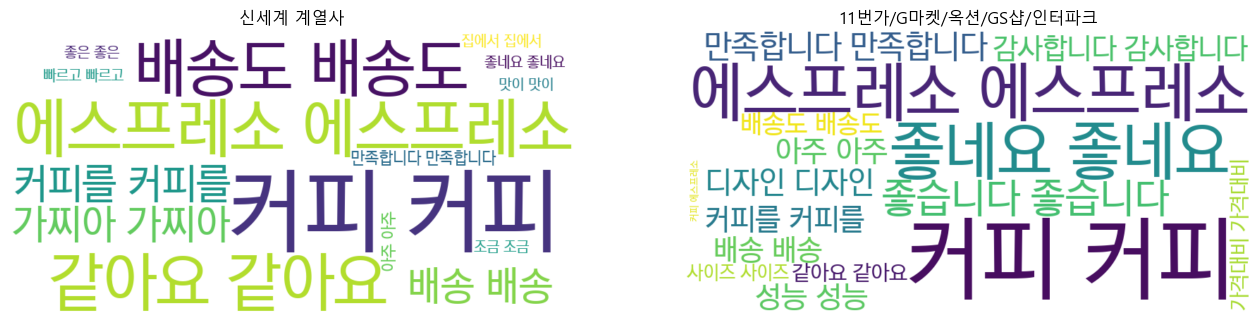

In [16]:
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to clean and tokenize reviews
def extract_keywords(reviews, top_n=15):
    words = re.findall(r'\w+', ' '.join(reviews).lower())
    stopwords = ['너무', '정말', '좋아요', '더', '많이', '잘', '좀', '아직', '이것', '저것']  # Common stopwords to exclude
    filtered_words = [word for word in words if word not in stopwords and len(word) > 1]
    return Counter(filtered_words).most_common(top_n)

selected_malls_keywords = extract_keywords(selected_malls_data['review'], top_n=15)

specific_other_malls_keywords = extract_keywords(specific_other_malls_data['review'], top_n=15)

# Combine keywords into strings for word clouds
selected_keywords_text = ' '.join([word for word, count in selected_malls_keywords for _ in range(count)])
specific_other_keywords_text = ' '.join([word for word, count in specific_other_malls_keywords for _ in range(count)])

# Generate word clouds
wordcloud_selected_malls = WordCloud(font_path='C:\Windows\Fonts\LG PC.ttf',  
                      width=800, height=400, background_color='white').generate(selected_keywords_text)

wordcloud_other_malls = WordCloud(font_path='C:\Windows\Fonts\LG PC.ttf',  
                      width=800, height=400, background_color='white').generate(specific_other_keywords_text)

# Display the word clouds side by side
plt.figure(figsize=(16, 8))

# Word cloud for Shinsegae/Emart/SSG
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_selected_malls, interpolation='bilinear')
plt.axis('off')
plt.title("신세계 계열사")

# Word cloud for 11번가/G마켓/옥션/GS샵/인터파크
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_other_malls, interpolation='bilinear')
plt.axis('off')
plt.title("11번가/G마켓/옥션/GS샵/인터파크")

plt.show()


- 신세계는 배송과 특정 제품 (가찌아)가 눈에 띈다
- 다른 쇼핑몰들은 디자인, 성능, 사이즈, 가성비 등 다양한 특징이 언급된다. 

### 리뷰 패턴

In [18]:
def find_repeated_phrases(reviews, min_length=15, top_n=10):
    phrases = []
    for review in reviews:
        phrases.extend([review[i:i + min_length] for i in range(len(review) - min_length + 1)])
    # Count most common repeated phrases
    return Counter(phrases).most_common(top_n)

selected_malls_repeated_phrases = find_repeated_phrases(selected_malls_data['review'], min_length=15, top_n=10)

specific_other_malls_repeated_phrases = find_repeated_phrases(specific_other_malls_data['review'], min_length=15, top_n=10)

selected_malls_repeated_phrases

[('...............', 32),
 (' 가찌아 클래식 프로를 선택', 4),
 ('가찌아 클래식 프로를 선택하', 4),
 ('찌아 클래식 프로를 선택하게', 4),
 ('아 클래식 프로를 선택하게 ', 4),
 ('사무실 이전 선물로 주문했는', 2),
 ('무실 이전 선물로 주문했는데', 2),
 ('실 이전 선물로 주문했는데 ', 2),
 (' 이전 선물로 주문했는데 너', 2),
 ('이전 선물로 주문했는데 너무', 2)]

In [19]:
specific_other_malls_repeated_phrases

[('///////////////', 321),
 ('그 외 도움이 될 만한 사용', 148),
 (' 외 도움이 될 만한 사용후', 148),
 ('외 도움이 될 만한 사용후기', 148),
 (' 도움이 될 만한 사용후기 ', 148),
 ('도움이 될 만한 사용후기 :', 145),
 ('디자인/사이즈/성능/사용편의', 136),
 ('자인/사이즈/성능/사용편의성', 136),
 ('인/사이즈/성능/사용편의성 ', 134),
 ('/사이즈/성능/사용편의성 :', 134)]

- 왜 둘 다 의미없는 패턴이 가장 많이 나왔을까? 
- 그 외는 신세계도, 다른 회사도 리뷰 패턴이 비슷하다